# Quick Start

In [1]:
# Filter out all RuntimeWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import logging 
logging.getLogger("stumpy").setLevel(logging.ERROR)

In [2]:
import pandas as pd
import numpy as np

dataset_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'

df = pd.read_csv(dataset_link)
df = df.dropna().reset_index()
df = df.drop(['index', 'No', 'day', 'month', 'year', 'hour'], axis=1)
df['cbwd'] = df['cbwd'].astype('category').cat.codes

normalize = True
standardize = False

def _normalize(x):
    return (x - x.min()) / (x.max() - x.min())
def _standardize(x):
    return (x - x.mean()) / x.std()

if normalize:
    df = df.apply(_normalize, axis=0)       
elif standardize:
    df = df.apply(_standardize, axis=0)


In [3]:
print(df.head(10))
print(len(df.index), len(df.columns))

      pm2.5      DEWP      TEMP      PRES      cbwd       Iws        Is   Ir
0  0.129779  0.352941  0.245902  0.527273  0.666667  0.002372  0.000000  0.0
1  0.148893  0.367647  0.245902  0.527273  0.666667  0.003947  0.000000  0.0
2  0.159960  0.426471  0.229508  0.545455  0.666667  0.005522  0.000000  0.0
3  0.182093  0.485294  0.229508  0.563636  0.666667  0.008690  0.037037  0.0
4  0.138833  0.485294  0.229508  0.563636  0.666667  0.010265  0.074074  0.0
5  0.109658  0.485294  0.213115  0.563636  0.666667  0.011840  0.111111  0.0
6  0.105634  0.485294  0.213115  0.581818  0.666667  0.015008  0.148148  0.0
7  0.124748  0.485294  0.229508  0.600000  0.666667  0.018176  0.000000  0.0
8  0.120724  0.470588  0.213115  0.600000  0.666667  0.021344  0.000000  0.0
9  0.132797  0.485294  0.229508  0.618182  0.666667  0.024512  0.000000  0.0
41757 8


In [4]:
def create_sequences(X, y, n_steps=24):
    for i in range(len(X) - (n_steps + 2)):
        start = i
        end = i + n_steps
        yield X[start: end].values, y[end + 1]

In [5]:
sequences = create_sequences(X=df.drop(['pm2.5'], axis=1), y=df['pm2.5'])
X, y = zip(*list(sequences))

In [6]:
X = np.asarray(X)
y = np.asarray(y)
print(X.shape)
print(y.shape)

(41731, 24, 7)
(41731,)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,random_state=13
)

In [8]:
# Build simple model
from tensorflow.keras import datasets, layers, models
cnn_model = models.Sequential()
cnn_model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(24, 7)))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Conv1D(64, 3, activation='relu'))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(50, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(1))

In [9]:
cnn_model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error']
                  )

history = cnn_model.fit(X_train, 
                        y_train, 
                        epochs=50, 
                        validation_data=(X_test, y_test), 
                        verbose=0
                        )

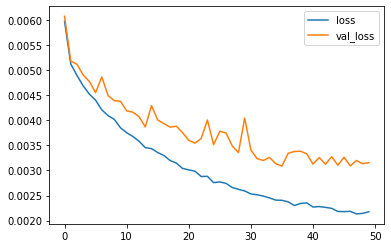

In [10]:
import matplotlib.pyplot as plt
loss = history.history.get("loss")
val_loss = history.history.get("val_loss")
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()

In [12]:
from functools import partial
# Create predict_fn for keras
def predict_fn(x, keras_model):
    if len(x.shape) == 2:
        prediction = keras_model.predict(x[np.newaxis]).ravel()
    else:
        prediction = keras_model.predict(x).ravel()
    return prediction

# Explain the prediction made by cnn_model
cnn_fn = partial(predict_fn, keras_model=cnn_model)

In [33]:
# Prepare a sample
sample = X_test[0]
print(sample.shape)
print(cnn_fn(sample))

(24, 7)
[0.2390903]


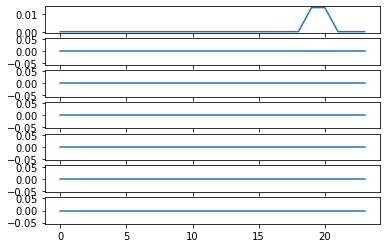

In [14]:
from tsmule.xai.lime import LimeTS
explainer = LimeTS()
xcoef = explainer.explain(sample, cnn_fn)
_, features = xcoef.shape
fig, axs = plt.subplots(features)
for i in range(features):
    axs[i].plot(xcoef[:, i])

In [15]:
# If the target is normalized, and too small, we set alpha smaller to infer.
from sklearn import linear_model
explainer._kernel = linear_model.Lasso(alpha=0.001)
xcoef = explainer.explain(sample, cnn_fn)

fig, axs = plt.subplots(features)
for i in range(features):
    axs[i].plot(xcoef[:, i])

In [16]:
from tsmule.xai.evaluation import PerturbationAnalysis
from sklearn import metrics

# get relevance/explanations
samples_X = X_test[:10]
samples_y = y_test[:10]

explainer._kernel = linear_model.Lasso(alpha=0.001)
relevance = [explainer.explain(s, cnn_fn) for s in samples_X]

In [32]:
# Evaluation the explanation
pa = PerturbationAnalysis()
scores = pa.analysis_relevance(samples_X, samples_y, relevance, 
                               predict_fn=cnn_fn,
                               eval_fn=metrics.mean_squared_error)

is_valid = (scores["original"] <= scores["random"] <= scores["percentile"])
print(("valid" if is_valid else "invalid") + " explanation")
scores

valid explanation


{'original': 0.005846083112844046,
 'percentile': 0.014457936563684918,
 'random': 0.010133240862548626}